# Naive bayes classifier

Used libraries are from the python standard library, sklearn, numpy and matplotlib

In [1]:
import math
from random import randrange
import pickle

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split


# For comparison purpose
from sklearn.naive_bayes import GaussianNB

First, the **remove_rand_class** function will randomly choose a class to delete from a dataset



In [2]:
def remove_rand_class(features_set, classes, target_names):
    class_to_rm = randrange(len(target_names))
    to_remove = sorted([i for i, x in enumerate(classes) if x == class_to_rm], reverse=True)
    for i in to_remove:
        features_set.pop(i)
        classes.pop(i)
    target_names.pop(class_to_rm)

We can now build our Naive Bayes Classifier. 
For this exercise I choosed the Gaussian implementation of the algorithm. 
To fit our classifier to our data, the method **fit** will arrange the dataset and compute some properties.

As our prediction algorithm requires the mean and the standard deviation for each feature for each classes we will do it in this step to avoid heavy computation while doing the prediction, this is done trough the **FeaturesStats** class. And to ensure an O(1) access during the prediction to these data I used a dictionary.


I added to this class a **score** method to get the mean accuracy of our fitted classifier instance. And the **save_model** and **fit_from_file** methods allows us to save the model and to use it in another execution without recomputing everything.

In [3]:
class FeatureStats:
    def __init__(self, data):
        self.length = len(data)
        self.mean = np.mean(data)
        self.stdev = np.std(data)


class NaiveBayes:
    def __init__(self, algorithm="gaussian"):
        self.algorithm = algorithm
        self.model = None

    """
    Create a NaiveBayes model
    """
    def fit(self, values, classes):
        ds = {}
        ds_features = {}

        for i in range(len(values) - 1):
            if not classes[i] in ds:
                ds[classes[i]] = [values[i]]
            else:
                ds[classes[i]].append(values[i])

        for class_id, features in ds.items():
            ds_features[class_id] = [FeatureStats(feature) for feature in zip(*features)]

        if self.algorithm == "gaussian":
            self.model = GNBModel(ds, ds_features, len(values))
            return self
        raise NotImplementedError()

    """
    Predict classes based on features
    """
    def predict(self, features_set):
        if not self.model:
            raise Exception("Classifier instance not fitted")
        return self.model.predict(features_set)

    """
    Mean accuracy for this model
    """
    def score(self, features_set, classes):
        if not self.model:
            raise Exception("Classifier instance not fitted")
        tp = 0
        predicted = self.predict(features_set)

        for i, _ in enumerate(classes):
            if classes[i] == predicted[i]:
                tp += 1
        return tp / float(len(features_set))

    """
    Save the model to a binary pickle file
    """
    def save_model(self, filename):
        pickle.dump(self.model, open(filename, "wb"))

    """
    Load the model from a binary pickle file
    """
    def fit_from_file(self, filename):
        self.model = pickle.load(open(filename, "rb"))
        return self

At the end of our **fit** method, the classifier will instanciate our model with the class GNBModel.

In the model we can find the **predict** method wich is the basic naive bayes algorithm:
$$
ŷ = \arg \max_y P(y)\begin{equation*}
\prod_{i=1}^{n} P(x_i|y)
\end{equation*}
$$

I chosed the gaussian implementation of the algorithm where $P(x_i|y)$ is estimated with:
$$
P(x_i|y) = \frac{1}{\sqrt{2\pi\sigma_y^2}} exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma_y^2}\right)
$$

In [4]:
class GNBModel:
    def __init__(self, ds, ds_features, rows):
        self.ds = ds
        self.ds_features = ds_features
        self.rows = rows

    """
    Predict classes based on features
    """
    def predict(self, features_set):
        result = []

        for features in features_set:
            prob = {}

            for class_id, class_stats in self.ds_features.items():
                prob[class_id] = class_stats[0].length / float(self.rows)
                for i, feature_stats in enumerate(class_stats):
                    prob[class_id] *= GNBModel.gaussian_probability(features[i],
                                                                    feature_stats.mean,
                                                                    feature_stats.stdev)
            result.append(max(prob, key=prob.get))
        return result

    """
    Estimate P(xi|y) using gaussian distribution
    """
    def gaussian_probability(xi, mean, stdev):
        return (1 / (math.sqrt(2 * math.pi) * stdev)) * math.exp(-((xi - mean)**2 / (2 * stdev**2)))

In order to better evaluate my classifier I builded a **ConfusionMatrix** wich can be build from results of the **predict** method and the actual classes of the test set.

I also have created a function to display it for this notebook

In [5]:
class ConfusionMatrix:
    def __init__(self, matrix):
        self.matrix = matrix
        self.fp = matrix.sum(axis=0) - np.diag(matrix)
        self.tp = np.diag(matrix)
        self.fn = matrix.sum(axis=1) - np.diag(matrix)
        self.tn = matrix.sum() - (self.fp + self.fn + self.tp)

    def __str__(self):
        return str(self.matrix)

    """
    Build the matrix from actual vs predicted classes
    """
    def build_from(actuals, predicted):
        matrix = {}
        classes = set(actuals)
        size = len(classes)

        for c in classes:
            matrix[c] = {ci: 0 for ci in classes}

        for actual, pred in zip(actuals, predicted):
            matrix[actual][pred] += 1

        result = np.empty(shape=(size, size), dtype=int)
        for i, key in enumerate(matrix):
            result[i] = [matrix[key][k] for k in matrix[key]]

        return ConfusionMatrix(result)

    def accuracy(self):
        return np.trace(self.matrix) / float(np.sum(self.matrix))

    """
    true positive rate / recall
    """
    def tpr(self):
        return self.tp / (self.tp + self.fn)

    """
    false positive rate / fall-out
    """
    def fpr(self):
        return self.fp / (self.tn + self.fp)
    
def plot_confusion_matrix(ax, cm, target_names, title):
    ax.imshow(cm.matrix, interpolation="nearest", cmap=plt.get_cmap("Greens"))

    switch = cm.matrix.max() / 2
    for i in range(cm.matrix.shape[0]):
        for j in range(cm.matrix.shape[1]):
            color = "white" if cm.matrix[i, j] > switch else "black"
            ax.text(j, i, cm.matrix[i, j],
                     horizontalalignment="center",
                     color=color)

    ticks = np.arange(len(target_names))
    accuracy = cm.accuracy() * 100
    ax.set(xticks=ticks, xticklabels=target_names,
           yticks=ticks, yticklabels=target_names,
           ylabel="Actual", xlabel=f"Predicted\n\naccuracy={accuracy:0.2f}%",
           title=title)

Now we can write an example on the iris dataset with one train set and one test set

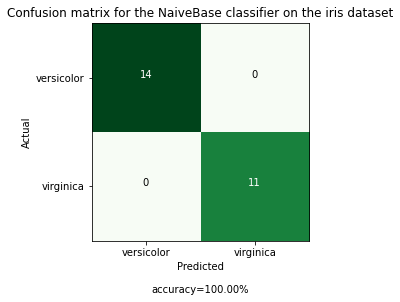

In [6]:
ds = datasets.load_iris()
target_names = ds.target_names.tolist()
X = ds.data.tolist()
y = ds.target.tolist()

remove_rand_class(X, y, target_names)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

nb = NaiveBayes()
result = nb.fit(Xtrain, ytrain).predict(Xtest)
cm = ConfusionMatrix.build_from(ytest, result)

plot_confusion_matrix(plt.subplot(), cm, target_names, "Confusion matrix for the NaiveBase classifier on the iris dataset")

Now that we have a classifier wich perform well on our dataset we can implement the cross validation method and compare the implementation with the sklearn one.

To do the cross validation we need to split our dataset in k random batches of the same size, this is done trough the **kfold** function. 

In [7]:
"""
Split a dataset in k random batches of the same size
"""
def kfold(dataset, k):
    batch_size = int(len(dataset[0]) / k)
    result = []
    features_clone = list(dataset[0])
    classes_clone = list(dataset[1])

    for _ in range(k):
        batch_features = []
        batch_classes = []
        for _ in range(batch_size):
            rrange = randrange(len(features_clone))
            batch_features.append(features_clone.pop(rrange))
            batch_classes.append(classes_clone.pop(rrange))
        result.append([batch_features, batch_classes])
    return result

The cross validation algorithm will take each batch as a train set and the others as test set. For each step we will compute a confusion matrix to get the true and false positive rate to build a ROC plot later and the accuracy. And we will do the mean on these data.

In [8]:
"""Find the true positive rate and false positive rate for a classifier on k batches"""
def cross_validation(batches, algofn):
    tprs = []
    accuracies = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, batch in enumerate(batches):
        train_set = list(map(lambda x: sum(list(x), []),
                             zip(*(batches[:i] + batches[i + 1:]))))
        result = algofn(train_set, batch[0])
        matrix = ConfusionMatrix.build_from(batch[1], result)
        interp_tpr = np.interp(mean_fpr, matrix.fpr(), matrix.tpr())
        interp_tpr[0] = 0
        tprs.append(interp_tpr)
        accuracies.append(matrix.accuracy())

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1
    mean_accuracy = np.mean(accuracies)

    return mean_accuracy, mean_tpr, mean_fpr

We can plot these data and compute the AUC.

The AUC is approximated using the trapezoidal rule.

In [9]:
"""Approximate area with the trapezoidal rule"""
def auc(x, y):
    dx = np.diff(x)
    if np.any(dx < 0) and np.all(dx <= 0):
        return -np.trapz(y, x)
    return np.trapz(y, x)

"""
Draw an ROC plot for the true positive rate and the false positive rate
and display the AUC value
"""
def plot_roc(ax, accuracy, tpr, fpr, title):
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r")

    auc_value = auc(fpr, tpr)
    ax.plot(fpr, tpr, color="b",
            label=f"AUC = {auc_value}",
            lw=2)

    acc = accuracy * 100
    ax.set(xlim=[-0.05, 1.05],
           ylim=[-0.05, 1.05],
           xlabel=f"False positive rate / Fall-out\n\nMean accuracy={acc:0.2f}%",
           ylabel="True positive rate / Recall",
           title=title)
    ax.legend(loc="lower right")

Now we can compare our classifier to the sklearn one

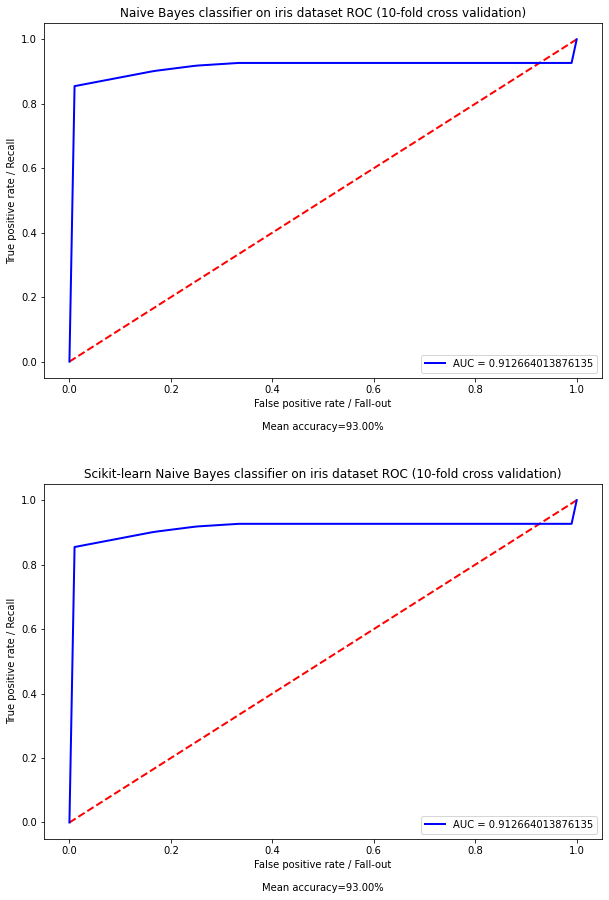

In [14]:
    ds = datasets.load_iris()
    target_names = ds.target_names.tolist()
    X = ds.data.tolist()
    y = ds.target.tolist()

    remove_rand_class(X, y, target_names)
    
    k = 10
    batches = kfold([X, y], k)

    nb = NaiveBayes()
    acc, tpr, fpr = cross_validation(batches, lambda train, test: nb.fit(train[0], train[1]).predict(test))


    # Sklearn Gaussian Naive Bayes classifier
    gnb = GaussianNB()
    acc2, tpr2, fpr2 = cross_validation(batches, lambda train, test: gnb.fit(train[0], train[1]).predict(test).tolist())

    fig, (ax1, ax2) = plt.subplots(2, 1)
    plt.subplots_adjust(hspace=0.3)
    fig.set_size_inches(10, 15)
    plot_roc(ax1, acc, tpr, fpr, f"Naive Bayes classifier on iris dataset ROC ({k}-fold cross validation)")
    plot_roc(ax2, acc2, tpr2, fpr2, f"Scikit-learn Naive Bayes classifier on iris dataset ROC ({k}-fold cross validation)")